# Simulation Notebook

The point of this notebook is to guide you through a simulation process using this Connectomics Software. In order to run a simulation, you need to set up:

1. A database object for querying ground truth data 
2. A ground truth dataset to simulate
2. A labeling unit object and its parameters 
3. An optical unit object and its parameters 

Both units take a set of optional parameters. These are indicated in their corresponding subsections (see below). This notebook prints out the resulting image stacks and allows you to save them in the desired format (TIFF, GIF or PNG sequence)

## Running a simulation

### *Database connection* 

Create a DatabaseSession object and give it a path to connect to. The database provides the ground truth used in the simuation.

In [1]:
import sys; sys.path.insert(0, "../")
from database.models import DatabaseSession

path = "/Users/Jeremy/Documents/Neuro/kasthuri_1100_1200.db"
ds = DatabaseSession(path) # Connects to the Database at this path, creates a new one if it can't find it

### *Ground Truth*

Now we select a ground truth dataset to use. We can print out the available datasets below :

In [2]:
import database.methods.datasets as d

gt_dataset_names = d.get_all_dataset_names_of_type(ds, 'ground_truth')
gt_datasets = []
print "Name, dataset_id, volume_dimensions, voxel_dimensions_nm\n"
for name in gt_dataset_names:#Prints out all the available datasets
    id = d.get_dataset_id(ds, name)
    dim = d.get_volume_dimensions(ds, id)
    voxel_dim = d.get_voxel_dimensions_nm(ds, id)
    print (name, id, dim, voxel_dim)
    gt_datasets.append((name, id, dim, voxel_dim))

Name, dataset_id, volume_dimensions, voxel_dimensions_nm

(u'Kasthuri', 1, (10752, 13312, 1849), (6, 6, 30))


Now select a dataset_id, and visualize it below to ensure that you select appropriate bounds :

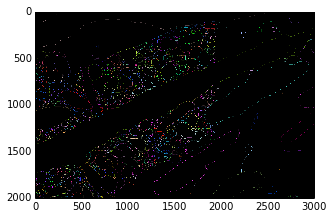

In [3]:
import visualization.methods as v
import database.methods.connectomics as c
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython import display


%matplotlib inline

#Select dataset_id:

selected_gt_id = 1

#Don't modify below
offset_input = widgets.IntText(value=0, description='Offset:  ',)
x_min = widgets.IntText(value=0, description='X_min:  ',)
x_max = widgets.IntText(value=100, description='X_max:  ',)
y_min = widgets.IntText(value=0, description='Y_min:  ',)
y_max = widgets.IntText(value=100, description='Y_max:  ',)
show_slice_button = widgets.Button(description='Go to slice',)
display.display(widgets.VBox((x_min, x_max, y_min, y_max)))
display.display(widgets.HBox((offset_input, show_slice_button)))

def show_slice(value):
    display.clear_output()
    plt.figure(figsize = (5, 5))
    dims = gt_datasets[selected_gt_id - 1][2]
    bounds = [x_min.value, x_max.value, y_min.value, y_max.value, offset_input.value, offset_input.value + 1]
    membrane_dict = c.get_voxels_in_volume_by_cell(ds, selected_gt_id, bounds,\
                 include_body = False, include_membrane = True)
    the_vol = v.get_composite(ds, membrane_dict, (bounds[1] - bounds[0], bounds[3] - bounds[2], 1))
    plt.imshow(np.squeeze(the_vol))

show_slice_button.on_click(show_slice)

In [9]:
membrane_dict = c.get_voxels_in_volume_by_cell(ds, 1, [7000, 7500, 7000, 7500, 1100, 1101],\
                 include_body = False, include_membrane = True)

In [28]:
import json

mem = {str(k):v.tolist() for k,v in membrane_dict.items()}
with open('/Users/Jeremy/Documents/my_dict.json', 'w') as f:
    json.dump(mem, f)

# elsewhere...



In [34]:
with open('/Users/Jeremy/Documents/my_dict.json') as f:
    my_dict = json.load(f)

membrane_dict2 = {int(k):np.array(v) for k,v in membrane_dict.items()}

In [10]:
print membrane_dict[6657]



[[460 260   0]
 [461 260   0]
 [462 260   0]
 [463 260   0]
 [464 260   0]
 [465 260   0]
 [466 260   0]
 [467 260   0]
 [460 261   0]
 [467 261   0]
 [460 262   0]
 [467 262   0]
 [460 263   0]
 [467 263   0]
 [452 264   0]
 [453 264   0]
 [454 264   0]
 [455 264   0]
 [456 264   0]
 [457 264   0]
 [458 264   0]
 [459 264   0]
 [460 264   0]
 [467 264   0]
 [452 265   0]
 [467 265   0]
 [452 266   0]
 [467 266   0]
 [452 267   0]
 [467 267   0]
 [452 268   0]
 [467 268   0]
 [452 269   0]
 [467 269   0]
 [452 270   0]
 [467 270   0]
 [452 271   0]
 [467 271   0]
 [448 272   0]
 [449 272   0]
 [450 272   0]
 [451 272   0]
 [452 272   0]
 [467 272   0]
 [468 272   0]
 [469 272   0]
 [470 272   0]
 [471 272   0]
 [448 273   0]
 [471 273   0]
 [448 274   0]
 [471 274   0]
 [448 275   0]
 [471 275   0]
 [436 276   0]
 [437 276   0]
 [438 276   0]
 [439 276   0]
 [440 276   0]
 [441 276   0]
 [442 276   0]
 [443 276   0]
 [444 276   0]
 [445 276   0]
 [446 276   0]
 [447 276   0]
 [448 276 

Select the desired bounds (make sure to check these with the tool above) :

In [4]:
xy_bounds = [7000, 9000, 7000, 9000]
z_offset = 1120
number_of_slices = 10

### *Labeling unit and Expansion*

We now create a Labeling unit. There is only one type of labeling which is currently available, namely brainbow. The following parameters can be passed to the labeling unit:

Here, we initialize it with the default parameters:

|  Parameter |  Default Value |
|---|---|
| protein_density  |  0.80 |
| prob_of_infection  |  0.25 |
| antibody_amplification_factor  | 5  |
| fluors  | ['ATTO488', 'ATTO550', 'ATTO647N']  | 

Now select the desired labeling parameters :

In [35]:
from simulation.models.labeling import BrainBowUnit

#Input other parameteres if needed
labeling_unit = BrainBowUnit(ds, prob_of_infection = 0.25, protein_density=0.05, fluor_noise = 0.0001)
print labeling_unit.get_param_dict()

{'prob_of_infection': 0.25, 'fluor_noise': 9.999999747378752e-05, 'fluor_types_used': ['ATTO488', 'ATTO550', 'ATTO647N'], 'antibody_amplification_factor': 5, 'protein_density': 0.05000000074505806}


Select an expansion factor :

In [36]:
expansion_factor = 20

Now run labeling:

In [37]:
from math import ceil

print "Loading... "
upper_bound = 800 #nm
voxel_dims = np.array(d.get_voxel_dimensions_nm(ds, selected_gt_id), np.int)
slices_required = ceil(float(upper_bound) / float(expansion_factor * voxel_dims[2]))
real_bounds = [xy_bounds[0], xy_bounds[1], xy_bounds[2], xy_bounds[3], z_offset - slices_required\
               - number_of_slices * slices_required / 2, z_offset + number_of_slices\
               * slices_required / 2 +  slices_required]
dims = [real_bounds[1] - real_bounds[0], real_bounds[3] - real_bounds[2], real_bounds[5] - real_bounds[4]]
membranes = c.get_voxels_in_volume_by_cell(ds, selected_gt_id, real_bounds,\
                                           include_body = False,  include_membrane = True)
num_channels =  len(labeling_unit.fluor_types_used)
(fluorophores, fluorophores_gt) = labeling_unit.perform_labeling(membranes, dims, voxel_dims)
print "Done."

Loading... 
Done.


And run the expansion :

In [38]:
from simulation.methods import perform_expansion, perform_expansion_gt

print "Loading... "
volume = perform_expansion(fluorophores, expansion_factor)
volume_gt = perform_expansion_gt(fluorophores_gt, expansion_factor)
print "Done."

Loading... 
Done.


### *Optical Unit*

Next we setup the optical unit. There is only one method of imaging currently implemented, which is the confocal microscope. The optical unit takes the following set of optional parameters:

|  Parameter |  Default Value |
|---|---|
| laser_wavelengths  |  [488, 565, 660] |
|  laser_power | [50, 50, 50] |
| laser_percentage  |  [0.25, 0.25, 0.25] |
| baseline  |  50 |
| std_dev_baseline  | 15  |
| filters  | [[450, 550], [550, 625], [625, 950]] | 
| exposure_time  |  1 |
|  numerical_aperture |  1.15 |
| objective_efficiency  |  0.8 |
| detector_efficiency  |  0.6 |
| focal_plane_depth  | 500  |
| objective_factor  | 40.0  | 
| pixel_size  |  6500 |
| precision  |  1 |


In [39]:
from simulation.models.optics import Confocal

#Input other parameteres if needed
optical_unit = Confocal(ds, baseline = 0, std_dev_baseline=0, numerical_aperture = 0.8)
optical_unit.calculate_parameters(voxel_dims, dims, expansion_factor)
print optical_unit.get_param_dict()

{'exposure_time': 0.10000000149011612, 'objective_efficiency': 0.800000011920929, 'laser_power': [50, 50, 50], 'baseline': 0.0, 'objective_factor': 40.0, 'detector_efficiency': 0.6000000238418579, 'laser_wavelengths': [488, 565, 660], 'focal_plane_depth': 500.0, 'precision': 1.0, 'filters': [[450, 550], [550, 625], [625, 950]], 'objective_back_aperture': 1.0, 'numerical_aperture': 0.800000011920929, 'laser_percentage': [0.25, 0.25, 0.25], 'pixel_size': 6500, 'std_dev_baseline': 0.0}


Run optics :

In [40]:
print "Loading... "
channels = []
new_dims = np.array([expansion_factor * i for i in dims], np.int)
for channel in range(num_channels):
    fluo_volume = optical_unit.resolve_volume(volume, new_dims, labeling_unit.fluor_types_used, channel)
    channels.append(fluo_volume)

fluo_volume_gt = optical_unit.resolve_ground_truth(volume_gt, new_dims)

#Stack channels
images = []
images_gt = []
for i in range(1, min(number_of_slices + 1, fluo_volume.shape[0])):
    images.append(np.stack([np.squeeze(fluorophore_volume[i,:,:]) for fluorophore_volume in channels], axis=-1))
    images_gt.append(fluo_volume_gt[i, :, :])
print "Done."

Loading... 
Done.


Now view :

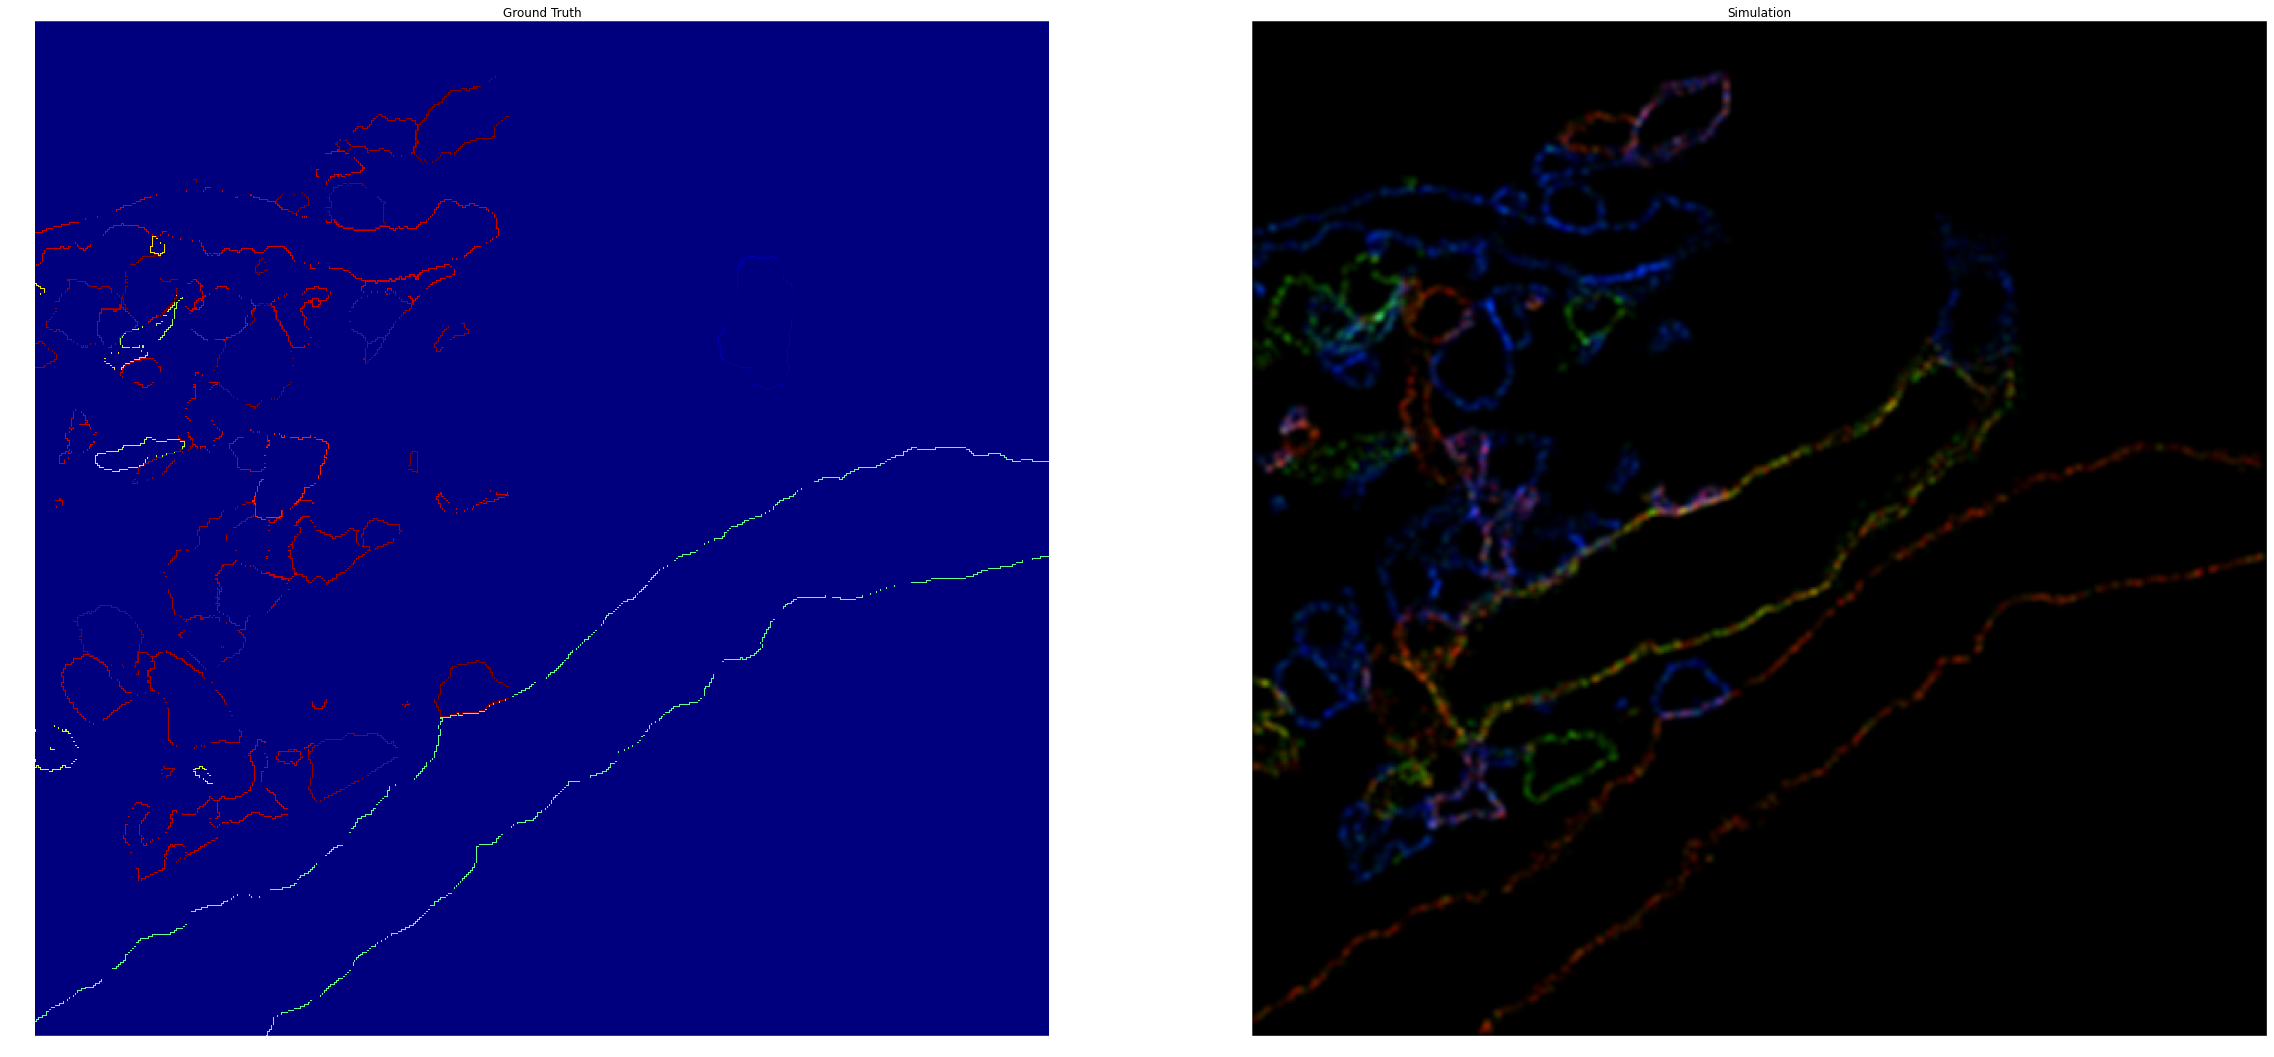

In [41]:
slider = widgets.IntSlider( value=0, min=0,\
        max=number_of_slices-1, step=1, description="Slice number: ",)

def f(x):
    plt.figure(figsize=(40, 40))
    plt.subplot(1,2,1)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.imshow(images_gt[int(slider.value)], interpolation = 'none')
    plt.subplot(1,2,2)
    plt.title('Simulation')
    plt.axis('off')
    plt.imshow(np.squeeze(\
     images[int(slider.value)]), interpolation = 'none')

widgets.interact(f, x=slider)


### *Saving*

First select a destination path and a name:

In [42]:
from visualization.methods import make_gif, save_image_sequence, make_tiff_stack

dest = "/Users/Jeremy/Desktop/"
name = "Simulation_1"

To save as GIF :

In [24]:
make_gif(images, path=dest, name=name)
make_gif(images_gt, path=dest, name=name + '_gt')

AttributeError: 'numpy.ndarray' object has no attribute 'info'

To save as TIFF stack :

In [43]:
make_tiff_stack(images, path=dest, name=name, rgb=True, sixteen_bit_mode = False)
make_tiff_stack(images_gt, path=dest, name=name + '_gt', rgb=False, sixteen_bit_mode = False)

To save as image sequence :

In [ ]:
save_image_sequence(images, dest, name, rgb=True)
save_image_sequence(images_gt, dest, name + '_gt' rgb=False)